# 00 - Setup and Data Preprocessing

## Overview
This notebook handles the foundational setup for the multi-stage AI-powered resume screening system:
- Environment configuration and package installation
- Data loading from Hugging Face datasets
- Text extraction from PDF resumes
- Data anonymization (removing PII)
- Exploratory data analysis
- Data persistence to Google Drive/Kaggle storage

**Runtime**: CPU sufficient (GPU optional)

**Estimated Time**: 15-30 minutes

## 1. Environment Setup

In [1]:
# Check runtime environment
import sys
import os

# Detect platform
IN_COLAB = 'google.colab' in sys.modules
IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

print(f"Running in Google Colab: {IN_COLAB}")
print(f"Running in Kaggle: {IN_KAGGLE}")
print(f"Python version: {sys.version}")

# Check GPU availability
import subprocess
try:
    gpu_info = subprocess.check_output(['nvidia-smi'], encoding='utf-8')
    print("\nGPU Available:")
    print(gpu_info)
except:
    print("\nNo GPU detected (CPU mode - OK for this notebook)")

Running in Google Colab: True
Running in Kaggle: False
Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

No GPU detected (CPU mode - OK for this notebook)


## 2. Install Required Packages

In [2]:
%%capture
# Core ML and Data Processing
!pip install -U pip
!pip install datasets transformers torch
!pip install pandas numpy scikit-learn

# PDF Processing
!pip install PyPDF2 pdfminer.six pdfplumber

# NLP and Text Processing
!pip install spacy nltk
!python -m spacy download en_core_web_sm

# Data Exploration and Visualization
!pip install pandas-profiling ydata-profiling
!pip install matplotlib seaborn plotly

# Storage and Serialization
!pip install pyarrow fastparquet

# Utilities
!pip install tqdm python-dotenv

In [3]:
# Import all libraries
import pandas as pd
import numpy as np
import re
import json
import warnings
from pathlib import Path
from tqdm.auto import tqdm
from typing import List, Dict, Tuple

# PDF Processing
import PyPDF2
import pdfplumber
from pdfminer.high_level import extract_text as pdfminer_extract

# NLP
import spacy
from datasets import load_dataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## 3. Storage Configuration

In [4]:
# Setup storage paths - using local directory
from pathlib import Path

BASE_PATH = Path('./resume_screening_project')
print(f"💾 Using local storage: {BASE_PATH.absolute()}")

# Create directory structure
DATA_PATH = BASE_PATH / 'data'
PROCESSED_PATH = DATA_PATH / 'processed'
RAW_PATH = DATA_PATH / 'raw'
MODELS_PATH = BASE_PATH / 'models'
OUTPUTS_PATH = BASE_PATH / 'outputs'

for path in [DATA_PATH, PROCESSED_PATH, RAW_PATH, MODELS_PATH, OUTPUTS_PATH]:
    path.mkdir(parents=True, exist_ok=True)

print(f"✅ Storage configured at: {BASE_PATH}")
print(f"   - Data: {DATA_PATH}")
print(f"   - Models: {MODELS_PATH}")
print(f"   - Outputs: {OUTPUTS_PATH}")

💾 Using local storage: /content/resume_screening_project
✅ Storage configured at: resume_screening_project
   - Data: resume_screening_project/data
   - Models: resume_screening_project/models
   - Outputs: resume_screening_project/outputs


## 4. Load Datasets from Hugging Face

We'll use two datasets:
1. **netsol/resume-score-details**: Resume scoring data
2. **facehuggerapoorv/resume-jd-match**: Job description and resume matching pairs

In [5]:
# Load Dataset 1: Resume Score Details
print("Loading netsol/resume-score-details...")
try:
    dataset1 = load_dataset('netsol/resume-score-details', split='train')
    df_resume_scores = pd.DataFrame(dataset1)
    print(f"✅ Loaded {len(df_resume_scores)} records from resume-score-details")
    print(f"   Columns: {list(df_resume_scores.columns)}")
except Exception as e:
    print(f"⚠️ Error loading dataset 1: {e}")
    print("Creating synthetic dataset as fallback...")
    df_resume_scores = pd.DataFrame({
        'resume_text': ['Sample resume ' + str(i) for i in range(100)],
        'score': np.random.randint(60, 100, 100)
    })

Loading netsol/resume-score-details...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/1031 [00:00<?, ?it/s]

empty_additional_info_11.json: 0.00B [00:00, ?B/s]

empty_additional_info_1.json: 0.00B [00:00, ?B/s]

empty_additional_info_116.json: 0.00B [00:00, ?B/s]

empty_additional_info_12.json: 0.00B [00:00, ?B/s]

empty_additional_info_114.json: 0.00B [00:00, ?B/s]

empty_additional_info_0.json: 0.00B [00:00, ?B/s]

empty_additional_info_115.json: 0.00B [00:00, ?B/s]

empty_additional_info_117.json: 0.00B [00:00, ?B/s]

empty_additional_info_118.json: 0.00B [00:00, ?B/s]

empty_additional_info_120.json: 0.00B [00:00, ?B/s]

empty_additional_info_111.json: 0.00B [00:00, ?B/s]

empty_additional_info_10.json: 0.00B [00:00, ?B/s]

empty_additional_info_113.json: 0.00B [00:00, ?B/s]

empty_additional_info_110.json: 0.00B [00:00, ?B/s]

empty_additional_info_112.json: 0.00B [00:00, ?B/s]

empty_additional_info_121.json: 0.00B [00:00, ?B/s]

empty_additional_info_122.json: 0.00B [00:00, ?B/s]

empty_additional_info_13.json: 0.00B [00:00, ?B/s]

empty_additional_info_125.json: 0.00B [00:00, ?B/s]

empty_additional_info_16.json: 0.00B [00:00, ?B/s]

empty_additional_info_15.json: 0.00B [00:00, ?B/s]

empty_additional_info_14.json: 0.00B [00:00, ?B/s]

empty_additional_info_20.json: 0.00B [00:00, ?B/s]

empty_additional_info_2.json: 0.00B [00:00, ?B/s]

empty_additional_info_18.json: 0.00B [00:00, ?B/s]

empty_additional_info_19.json: 0.00B [00:00, ?B/s]

empty_additional_info_123.json: 0.00B [00:00, ?B/s]

empty_additional_info_124.json: 0.00B [00:00, ?B/s]

empty_additional_info_17.json: 0.00B [00:00, ?B/s]

empty_additional_info_21.json: 0.00B [00:00, ?B/s]

empty_additional_info_119.json: 0.00B [00:00, ?B/s]

empty_additional_info_23.json: 0.00B [00:00, ?B/s]

empty_additional_info_22.json: 0.00B [00:00, ?B/s]

empty_additional_info_3.json: 0.00B [00:00, ?B/s]

(…)_gibberish_job_description_match_20.json: 0.00B [00:00, ?B/s]

empty_additional_info_4.json: 0.00B [00:00, ?B/s]

empty_additional_info_8.json: 0.00B [00:00, ?B/s]

empty_additional_info_7.json: 0.00B [00:00, ?B/s]

(…)gibberish_job_description_match_278.json: 0.00B [00:00, ?B/s]

(…)gibberish_job_description_match_289.json: 0.00B [00:00, ?B/s]

empty_additional_info_6.json: 0.00B [00:00, ?B/s]

empty_additional_info_9.json: 0.00B [00:00, ?B/s]

empty_additional_info_5.json: 0.00B [00:00, ?B/s]

(…)gibberish_job_description_match_292.json: 0.00B [00:00, ?B/s]

(…)_gibberish_job_description_match_40.json: 0.00B [00:00, ?B/s]

(…)gibberish_job_description_match_497.json: 0.00B [00:00, ?B/s]

(…)gibberish_job_description_match_459.json: 0.00B [00:00, ?B/s]

(…)gibberish_job_description_match_398.json: 0.00B [00:00, ?B/s]

(…)gibberish_job_description_match_522.json: 0.00B [00:00, ?B/s]

(…)gibberish_job_description_match_545.json: 0.00B [00:00, ?B/s]

(…)gibberish_job_description_match_548.json: 0.00B [00:00, ?B/s]

(…)bberish_job_description_mismatch_18.json: 0.00B [00:00, ?B/s]

(…)d_gibberish_job_description_match_9.json: 0.00B [00:00, ?B/s]

(…)gibberish_job_description_match_576.json: 0.00B [00:00, ?B/s]

(…)gibberish_job_description_match_567.json: 0.00B [00:00, ?B/s]

invalid_gibberish_resume_match_362.json: 0.00B [00:00, ?B/s]

invalid_gibberish_resume_match_238.json: 0.00B [00:00, ?B/s]

invalid_gibberish_resume_match_311.json: 0.00B [00:00, ?B/s]

invalid_gibberish_resume_match_222.json: 0.00B [00:00, ?B/s]

invalid_gibberish_resume_match_470.json: 0.00B [00:00, ?B/s]

invalid_gibberish_resume_match_518.json: 0.00B [00:00, ?B/s]

invalid_gibberish_resume_match_562.json: 0.00B [00:00, ?B/s]

invalid_gibberish_resume_match_525.json: 0.00B [00:00, ?B/s]

(…)valid_gibberish_resume_mismatch_155.json: 0.00B [00:00, ?B/s]

invalid_gibberish_resume_match_571.json: 0.00B [00:00, ?B/s]

invalid_gibberish_resume_match_93.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_107.json: 0.00B [00:00, ?B/s]

invalid_gibberish_resume_match_6.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_142.json: 0.00B [00:00, ?B/s]

(…)valid_gibberish_resume_mismatch_193.json: 0.00B [00:00, ?B/s]

invalid_gibberish_resume_match_506.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_144.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_196.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_181.json: 0.00B [00:00, ?B/s]

(…)valid_gibberish_resume_mismatch_147.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_133.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_213.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_221.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_248.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_268.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_227.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_346.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_280.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_256.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_335.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_286.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_295.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_349.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_31.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_352.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_344.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_325.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_353.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_405.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_389.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_437.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_434.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_383.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_51.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_423.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_487.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_503.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_498.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_517.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_52.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_570.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_560.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_575.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_590.json: 0.00B [00:00, ?B/s]

(…)nvalid_job_description_mismatch_101.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_92.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_598.json: 0.00B [00:00, ?B/s]

(…)nvalid_job_description_mismatch_126.json: 0.00B [00:00, ?B/s]

(…)nvalid_job_description_mismatch_182.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_9.json: 0.00B [00:00, ?B/s]

(…)nvalid_job_description_mismatch_109.json: 0.00B [00:00, ?B/s]

(…)nvalid_job_description_mismatch_129.json: 0.00B [00:00, ?B/s]

invalid_job_description_match_594.json: 0.00B [00:00, ?B/s]

(…)nvalid_job_description_mismatch_138.json: 0.00B [00:00, ?B/s]

(…)nvalid_job_description_mismatch_185.json: 0.00B [00:00, ?B/s]

invalid_job_description_mismatch_2.json: 0.00B [00:00, ?B/s]

invalid_job_description_mismatch_49.json: 0.00B [00:00, ?B/s]

invalid_job_description_mismatch_75.json: 0.00B [00:00, ?B/s]

invalid_job_description_mismatch_27.json: 0.00B [00:00, ?B/s]

invalid_job_description_mismatch_74.json: 0.00B [00:00, ?B/s]

invalid_resume_match_104.json: 0.00B [00:00, ?B/s]

invalid_job_description_mismatch_84.json: 0.00B [00:00, ?B/s]

invalid_resume_match_125.json: 0.00B [00:00, ?B/s]

invalid_job_description_mismatch_97.json: 0.00B [00:00, ?B/s]

invalid_resume_match_163.json: 0.00B [00:00, ?B/s]

invalid_resume_match_230.json: 0.00B [00:00, ?B/s]

invalid_resume_match_162.json: 0.00B [00:00, ?B/s]

invalid_resume_match_111.json: 0.00B [00:00, ?B/s]

invalid_resume_match_129.json: 0.00B [00:00, ?B/s]

invalid_resume_match_240.json: 0.00B [00:00, ?B/s]

invalid_resume_match_100.json: 0.00B [00:00, ?B/s]

invalid_resume_match_122.json: 0.00B [00:00, ?B/s]

invalid_resume_match_270.json: 0.00B [00:00, ?B/s]

invalid_resume_match_28.json: 0.00B [00:00, ?B/s]

invalid_resume_match_279.json: 0.00B [00:00, ?B/s]

invalid_resume_match_286.json: 0.00B [00:00, ?B/s]

invalid_resume_match_288.json: 0.00B [00:00, ?B/s]

invalid_resume_match_404.json: 0.00B [00:00, ?B/s]

invalid_resume_match_34.json: 0.00B [00:00, ?B/s]

invalid_resume_match_364.json: 0.00B [00:00, ?B/s]

invalid_resume_match_406.json: 0.00B [00:00, ?B/s]

invalid_resume_match_425.json: 0.00B [00:00, ?B/s]

invalid_resume_match_478.json: 0.00B [00:00, ?B/s]

invalid_resume_match_428.json: 0.00B [00:00, ?B/s]

invalid_resume_match_485.json: 0.00B [00:00, ?B/s]

invalid_resume_match_50.json: 0.00B [00:00, ?B/s]

invalid_resume_match_516.json: 0.00B [00:00, ?B/s]

invalid_resume_match_502.json: 0.00B [00:00, ?B/s]

invalid_resume_match_55.json: 0.00B [00:00, ?B/s]

invalid_resume_match_489.json: 0.00B [00:00, ?B/s]

invalid_resume_match_523.json: 0.00B [00:00, ?B/s]

invalid_resume_match_504.json: 0.00B [00:00, ?B/s]

invalid_resume_match_560.json: 0.00B [00:00, ?B/s]

invalid_resume_match_554.json: 0.00B [00:00, ?B/s]

invalid_resume_match_582.json: 0.00B [00:00, ?B/s]

invalid_resume_match_583.json: 0.00B [00:00, ?B/s]

invalid_resume_match_579.json: 0.00B [00:00, ?B/s]

invalid_resume_match_597.json: 0.00B [00:00, ?B/s]

invalid_resume_match_606.json: 0.00B [00:00, ?B/s]

invalid_resume_match_83.json: 0.00B [00:00, ?B/s]

invalid_resume_match_633.json: 0.00B [00:00, ?B/s]

invalid_resume_match_634.json: 0.00B [00:00, ?B/s]

invalid_resume_match_611.json: 0.00B [00:00, ?B/s]

invalid_resume_match_629.json: 0.00B [00:00, ?B/s]

invalid_resume_mismatch_142.json: 0.00B [00:00, ?B/s]

invalid_resume_mismatch_29.json: 0.00B [00:00, ?B/s]

invalid_resume_mismatch_101.json: 0.00B [00:00, ?B/s]

invalid_resume_mismatch_50.json: 0.00B [00:00, ?B/s]

invalid_resume_mismatch_18.json: 0.00B [00:00, ?B/s]

invalid_resume_mismatch_65.json: 0.00B [00:00, ?B/s]

invalid_resume_mismatch_70.json: 0.00B [00:00, ?B/s]

invalid_resume_mismatch_74.json: 0.00B [00:00, ?B/s]

match_100.json: 0.00B [00:00, ?B/s]

invalid_resume_mismatch_83.json: 0.00B [00:00, ?B/s]

invalid_resume_mismatch_8.json: 0.00B [00:00, ?B/s]

invalid_resume_mismatch_92.json: 0.00B [00:00, ?B/s]

match_0.json: 0.00B [00:00, ?B/s]

match_1.json: 0.00B [00:00, ?B/s]

match_102.json: 0.00B [00:00, ?B/s]

invalid_resume_mismatch_90.json: 0.00B [00:00, ?B/s]

match_105.json: 0.00B [00:00, ?B/s]

match_101.json: 0.00B [00:00, ?B/s]

invalid_resume_mismatch_84.json: 0.00B [00:00, ?B/s]

match_104.json: 0.00B [00:00, ?B/s]

match_10.json: 0.00B [00:00, ?B/s]

match_103.json: 0.00B [00:00, ?B/s]

match_106.json: 0.00B [00:00, ?B/s]

match_107.json: 0.00B [00:00, ?B/s]

match_111.json: 0.00B [00:00, ?B/s]

match_120.json: 0.00B [00:00, ?B/s]

match_108.json: 0.00B [00:00, ?B/s]

match_11.json: 0.00B [00:00, ?B/s]

match_119.json: 0.00B [00:00, ?B/s]

match_115.json: 0.00B [00:00, ?B/s]

match_114.json: 0.00B [00:00, ?B/s]

match_109.json: 0.00B [00:00, ?B/s]

match_110.json: 0.00B [00:00, ?B/s]

match_118.json: 0.00B [00:00, ?B/s]

match_112.json: 0.00B [00:00, ?B/s]

match_12.json: 0.00B [00:00, ?B/s]

match_117.json: 0.00B [00:00, ?B/s]

match_116.json: 0.00B [00:00, ?B/s]

match_113.json: 0.00B [00:00, ?B/s]

match_121.json: 0.00B [00:00, ?B/s]

match_122.json: 0.00B [00:00, ?B/s]

match_129.json: 0.00B [00:00, ?B/s]

match_124.json: 0.00B [00:00, ?B/s]

match_13.json: 0.00B [00:00, ?B/s]

match_128.json: 0.00B [00:00, ?B/s]

match_131.json: 0.00B [00:00, ?B/s]

match_125.json: 0.00B [00:00, ?B/s]

match_136.json: 0.00B [00:00, ?B/s]

match_134.json: 0.00B [00:00, ?B/s]

match_127.json: 0.00B [00:00, ?B/s]

match_123.json: 0.00B [00:00, ?B/s]

match_126.json: 0.00B [00:00, ?B/s]

match_133.json: 0.00B [00:00, ?B/s]

match_132.json: 0.00B [00:00, ?B/s]

match_130.json: 0.00B [00:00, ?B/s]

match_135.json: 0.00B [00:00, ?B/s]

match_137.json: 0.00B [00:00, ?B/s]

match_142.json: 0.00B [00:00, ?B/s]

match_138.json: 0.00B [00:00, ?B/s]

match_139.json: 0.00B [00:00, ?B/s]

match_143.json: 0.00B [00:00, ?B/s]

match_140.json: 0.00B [00:00, ?B/s]

match_146.json: 0.00B [00:00, ?B/s]

match_147.json: 0.00B [00:00, ?B/s]

match_14.json: 0.00B [00:00, ?B/s]

match_141.json: 0.00B [00:00, ?B/s]

match_148.json: 0.00B [00:00, ?B/s]

match_144.json: 0.00B [00:00, ?B/s]

match_145.json: 0.00B [00:00, ?B/s]

match_150.json: 0.00B [00:00, ?B/s]

match_149.json: 0.00B [00:00, ?B/s]

match_15.json: 0.00B [00:00, ?B/s]

match_151.json: 0.00B [00:00, ?B/s]

match_154.json: 0.00B [00:00, ?B/s]

match_153.json: 0.00B [00:00, ?B/s]

match_155.json: 0.00B [00:00, ?B/s]

match_152.json: 0.00B [00:00, ?B/s]

match_158.json: 0.00B [00:00, ?B/s]

match_16.json: 0.00B [00:00, ?B/s]

match_157.json: 0.00B [00:00, ?B/s]

match_161.json: 0.00B [00:00, ?B/s]

match_163.json: 0.00B [00:00, ?B/s]

match_159.json: 0.00B [00:00, ?B/s]

match_160.json: 0.00B [00:00, ?B/s]

match_156.json: 0.00B [00:00, ?B/s]

match_164.json: 0.00B [00:00, ?B/s]

match_162.json: 0.00B [00:00, ?B/s]

match_165.json: 0.00B [00:00, ?B/s]

match_166.json: 0.00B [00:00, ?B/s]

match_167.json: 0.00B [00:00, ?B/s]

match_169.json: 0.00B [00:00, ?B/s]

match_168.json: 0.00B [00:00, ?B/s]

match_172.json: 0.00B [00:00, ?B/s]

match_170.json: 0.00B [00:00, ?B/s]

match_17.json: 0.00B [00:00, ?B/s]

match_179.json: 0.00B [00:00, ?B/s]

match_178.json: 0.00B [00:00, ?B/s]

match_176.json: 0.00B [00:00, ?B/s]

match_171.json: 0.00B [00:00, ?B/s]

match_180.json: 0.00B [00:00, ?B/s]

match_175.json: 0.00B [00:00, ?B/s]

match_173.json: 0.00B [00:00, ?B/s]

match_174.json: 0.00B [00:00, ?B/s]

match_18.json: 0.00B [00:00, ?B/s]

match_181.json: 0.00B [00:00, ?B/s]

match_177.json: 0.00B [00:00, ?B/s]

match_183.json: 0.00B [00:00, ?B/s]

match_182.json: 0.00B [00:00, ?B/s]

match_184.json: 0.00B [00:00, ?B/s]

match_185.json: 0.00B [00:00, ?B/s]

match_186.json: 0.00B [00:00, ?B/s]

match_195.json: 0.00B [00:00, ?B/s]

match_190.json: 0.00B [00:00, ?B/s]

match_193.json: 0.00B [00:00, ?B/s]

match_191.json: 0.00B [00:00, ?B/s]

match_188.json: 0.00B [00:00, ?B/s]

match_196.json: 0.00B [00:00, ?B/s]

match_189.json: 0.00B [00:00, ?B/s]

match_19.json: 0.00B [00:00, ?B/s]

match_187.json: 0.00B [00:00, ?B/s]

match_192.json: 0.00B [00:00, ?B/s]

match_194.json: 0.00B [00:00, ?B/s]

match_197.json: 0.00B [00:00, ?B/s]

match_198.json: 0.00B [00:00, ?B/s]

match_199.json: 0.00B [00:00, ?B/s]

match_203.json: 0.00B [00:00, ?B/s]

match_2.json: 0.00B [00:00, ?B/s]

match_202.json: 0.00B [00:00, ?B/s]

match_205.json: 0.00B [00:00, ?B/s]

match_200.json: 0.00B [00:00, ?B/s]

match_201.json: 0.00B [00:00, ?B/s]

match_206.json: 0.00B [00:00, ?B/s]

match_20.json: 0.00B [00:00, ?B/s]

match_209.json: 0.00B [00:00, ?B/s]

match_204.json: 0.00B [00:00, ?B/s]

match_210.json: 0.00B [00:00, ?B/s]

match_21.json: 0.00B [00:00, ?B/s]

match_208.json: 0.00B [00:00, ?B/s]

match_211.json: 0.00B [00:00, ?B/s]

match_207.json: 0.00B [00:00, ?B/s]

match_213.json: 0.00B [00:00, ?B/s]

match_215.json: 0.00B [00:00, ?B/s]

match_214.json: 0.00B [00:00, ?B/s]

match_216.json: 0.00B [00:00, ?B/s]

match_212.json: 0.00B [00:00, ?B/s]

match_217.json: 0.00B [00:00, ?B/s]

match_219.json: 0.00B [00:00, ?B/s]

match_220.json: 0.00B [00:00, ?B/s]

match_218.json: 0.00B [00:00, ?B/s]

match_222.json: 0.00B [00:00, ?B/s]

match_221.json: 0.00B [00:00, ?B/s]

match_224.json: 0.00B [00:00, ?B/s]

match_225.json: 0.00B [00:00, ?B/s]

match_22.json: 0.00B [00:00, ?B/s]

match_223.json: 0.00B [00:00, ?B/s]

match_226.json: 0.00B [00:00, ?B/s]

match_228.json: 0.00B [00:00, ?B/s]

match_229.json: 0.00B [00:00, ?B/s]

match_23.json: 0.00B [00:00, ?B/s]

match_232.json: 0.00B [00:00, ?B/s]

match_233.json: 0.00B [00:00, ?B/s]

match_227.json: 0.00B [00:00, ?B/s]

match_234.json: 0.00B [00:00, ?B/s]

match_231.json: 0.00B [00:00, ?B/s]

match_230.json: 0.00B [00:00, ?B/s]

match_235.json: 0.00B [00:00, ?B/s]

match_236.json: 0.00B [00:00, ?B/s]

match_237.json: 0.00B [00:00, ?B/s]

match_239.json: 0.00B [00:00, ?B/s]

match_238.json: 0.00B [00:00, ?B/s]

match_24.json: 0.00B [00:00, ?B/s]

match_240.json: 0.00B [00:00, ?B/s]

match_242.json: 0.00B [00:00, ?B/s]

match_245.json: 0.00B [00:00, ?B/s]

match_249.json: 0.00B [00:00, ?B/s]

match_250.json: 0.00B [00:00, ?B/s]

match_241.json: 0.00B [00:00, ?B/s]

match_244.json: 0.00B [00:00, ?B/s]

match_25.json: 0.00B [00:00, ?B/s]

match_243.json: 0.00B [00:00, ?B/s]

match_247.json: 0.00B [00:00, ?B/s]

match_248.json: 0.00B [00:00, ?B/s]

match_246.json: 0.00B [00:00, ?B/s]

match_251.json: 0.00B [00:00, ?B/s]

match_252.json: 0.00B [00:00, ?B/s]

match_253.json: 0.00B [00:00, ?B/s]

match_256.json: 0.00B [00:00, ?B/s]

match_260.json: 0.00B [00:00, ?B/s]

match_255.json: 0.00B [00:00, ?B/s]

match_254.json: 0.00B [00:00, ?B/s]

match_261.json: 0.00B [00:00, ?B/s]

match_266.json: 0.00B [00:00, ?B/s]

match_26.json: 0.00B [00:00, ?B/s]

match_258.json: 0.00B [00:00, ?B/s]

match_264.json: 0.00B [00:00, ?B/s]

match_262.json: 0.00B [00:00, ?B/s]

match_267.json: 0.00B [00:00, ?B/s]

match_265.json: 0.00B [00:00, ?B/s]

match_259.json: 0.00B [00:00, ?B/s]

match_263.json: 0.00B [00:00, ?B/s]

match_257.json: 0.00B [00:00, ?B/s]

match_268.json: 0.00B [00:00, ?B/s]

match_270.json: 0.00B [00:00, ?B/s]

match_27.json: 0.00B [00:00, ?B/s]

match_277.json: 0.00B [00:00, ?B/s]

match_269.json: 0.00B [00:00, ?B/s]

match_278.json: 0.00B [00:00, ?B/s]

match_275.json: 0.00B [00:00, ?B/s]

match_276.json: 0.00B [00:00, ?B/s]

match_272.json: 0.00B [00:00, ?B/s]

match_271.json: 0.00B [00:00, ?B/s]

match_282.json: 0.00B [00:00, ?B/s]

match_273.json: 0.00B [00:00, ?B/s]

match_274.json: 0.00B [00:00, ?B/s]

match_279.json: 0.00B [00:00, ?B/s]

match_280.json: 0.00B [00:00, ?B/s]

match_281.json: 0.00B [00:00, ?B/s]

match_28.json: 0.00B [00:00, ?B/s]

match_283.json: 0.00B [00:00, ?B/s]

match_285.json: 0.00B [00:00, ?B/s]

match_286.json: 0.00B [00:00, ?B/s]

match_297.json: 0.00B [00:00, ?B/s]

match_296.json: 0.00B [00:00, ?B/s]

match_295.json: 0.00B [00:00, ?B/s]

match_290.json: 0.00B [00:00, ?B/s]

match_293.json: 0.00B [00:00, ?B/s]

match_287.json: 0.00B [00:00, ?B/s]

match_291.json: 0.00B [00:00, ?B/s]

match_292.json: 0.00B [00:00, ?B/s]

match_284.json: 0.00B [00:00, ?B/s]

match_288.json: 0.00B [00:00, ?B/s]

match_29.json: 0.00B [00:00, ?B/s]

match_294.json: 0.00B [00:00, ?B/s]

match_289.json: 0.00B [00:00, ?B/s]

match_3.json: 0.00B [00:00, ?B/s]

match_298.json: 0.00B [00:00, ?B/s]

match_30.json: 0.00B [00:00, ?B/s]

match_31.json: 0.00B [00:00, ?B/s]

match_301.json: 0.00B [00:00, ?B/s]

match_299.json: 0.00B [00:00, ?B/s]

match_303.json: 0.00B [00:00, ?B/s]

match_305.json: 0.00B [00:00, ?B/s]

match_300.json: 0.00B [00:00, ?B/s]

match_302.json: 0.00B [00:00, ?B/s]

match_308.json: 0.00B [00:00, ?B/s]

match_309.json: 0.00B [00:00, ?B/s]

match_306.json: 0.00B [00:00, ?B/s]

match_304.json: 0.00B [00:00, ?B/s]

match_307.json: 0.00B [00:00, ?B/s]

match_310.json: 0.00B [00:00, ?B/s]

match_312.json: 0.00B [00:00, ?B/s]

match_311.json: 0.00B [00:00, ?B/s]

match_316.json: 0.00B [00:00, ?B/s]

match_321.json: 0.00B [00:00, ?B/s]

match_320.json: 0.00B [00:00, ?B/s]

match_322.json: 0.00B [00:00, ?B/s]

match_319.json: 0.00B [00:00, ?B/s]

match_324.json: 0.00B [00:00, ?B/s]

match_318.json: 0.00B [00:00, ?B/s]

match_315.json: 0.00B [00:00, ?B/s]

match_314.json: 0.00B [00:00, ?B/s]

match_313.json: 0.00B [00:00, ?B/s]

match_317.json: 0.00B [00:00, ?B/s]

match_323.json: 0.00B [00:00, ?B/s]

match_325.json: 0.00B [00:00, ?B/s]

match_32.json: 0.00B [00:00, ?B/s]

match_326.json: 0.00B [00:00, ?B/s]

match_332.json: 0.00B [00:00, ?B/s]

match_327.json: 0.00B [00:00, ?B/s]

match_329.json: 0.00B [00:00, ?B/s]

match_328.json: 0.00B [00:00, ?B/s]

match_335.json: 0.00B [00:00, ?B/s]

match_334.json: 0.00B [00:00, ?B/s]

match_333.json: 0.00B [00:00, ?B/s]

match_330.json: 0.00B [00:00, ?B/s]

match_331.json: 0.00B [00:00, ?B/s]

match_339.json: 0.00B [00:00, ?B/s]

match_33.json: 0.00B [00:00, ?B/s]

match_338.json: 0.00B [00:00, ?B/s]

match_337.json: 0.00B [00:00, ?B/s]

match_336.json: 0.00B [00:00, ?B/s]

match_340.json: 0.00B [00:00, ?B/s]

match_34.json: 0.00B [00:00, ?B/s]

match_341.json: 0.00B [00:00, ?B/s]

match_344.json: 0.00B [00:00, ?B/s]

match_343.json: 0.00B [00:00, ?B/s]

match_342.json: 0.00B [00:00, ?B/s]

match_345.json: 0.00B [00:00, ?B/s]

match_346.json: 0.00B [00:00, ?B/s]

match_347.json: 0.00B [00:00, ?B/s]

match_348.json: 0.00B [00:00, ?B/s]

match_350.json: 0.00B [00:00, ?B/s]

match_35.json: 0.00B [00:00, ?B/s]

match_351.json: 0.00B [00:00, ?B/s]

match_352.json: 0.00B [00:00, ?B/s]

match_353.json: 0.00B [00:00, ?B/s]

match_355.json: 0.00B [00:00, ?B/s]

match_356.json: 0.00B [00:00, ?B/s]

match_349.json: 0.00B [00:00, ?B/s]

match_357.json: 0.00B [00:00, ?B/s]

match_354.json: 0.00B [00:00, ?B/s]

match_358.json: 0.00B [00:00, ?B/s]

match_359.json: 0.00B [00:00, ?B/s]

match_360.json: 0.00B [00:00, ?B/s]

match_361.json: 0.00B [00:00, ?B/s]

match_362.json: 0.00B [00:00, ?B/s]

match_36.json: 0.00B [00:00, ?B/s]

match_363.json: 0.00B [00:00, ?B/s]

match_37.json: 0.00B [00:00, ?B/s]

match_364.json: 0.00B [00:00, ?B/s]

match_367.json: 0.00B [00:00, ?B/s]

match_373.json: 0.00B [00:00, ?B/s]

match_365.json: 0.00B [00:00, ?B/s]

match_369.json: 0.00B [00:00, ?B/s]

match_370.json: 0.00B [00:00, ?B/s]

match_366.json: 0.00B [00:00, ?B/s]

match_368.json: 0.00B [00:00, ?B/s]

match_372.json: 0.00B [00:00, ?B/s]

match_371.json: 0.00B [00:00, ?B/s]

match_375.json: 0.00B [00:00, ?B/s]

match_374.json: 0.00B [00:00, ?B/s]

match_376.json: 0.00B [00:00, ?B/s]

match_378.json: 0.00B [00:00, ?B/s]

match_377.json: 0.00B [00:00, ?B/s]

match_379.json: 0.00B [00:00, ?B/s]

match_38.json: 0.00B [00:00, ?B/s]

match_380.json: 0.00B [00:00, ?B/s]

match_383.json: 0.00B [00:00, ?B/s]

match_384.json: 0.00B [00:00, ?B/s]

match_385.json: 0.00B [00:00, ?B/s]

match_39.json: 0.00B [00:00, ?B/s]

match_386.json: 0.00B [00:00, ?B/s]

match_381.json: 0.00B [00:00, ?B/s]

match_387.json: 0.00B [00:00, ?B/s]

match_388.json: 0.00B [00:00, ?B/s]

match_392.json: 0.00B [00:00, ?B/s]

match_382.json: 0.00B [00:00, ?B/s]

match_390.json: 0.00B [00:00, ?B/s]

match_391.json: 0.00B [00:00, ?B/s]

match_389.json: 0.00B [00:00, ?B/s]

match_394.json: 0.00B [00:00, ?B/s]

match_395.json: 0.00B [00:00, ?B/s]

match_397.json: 0.00B [00:00, ?B/s]

match_401.json: 0.00B [00:00, ?B/s]

match_393.json: 0.00B [00:00, ?B/s]

match_396.json: 0.00B [00:00, ?B/s]

match_404.json: 0.00B [00:00, ?B/s]

match_402.json: 0.00B [00:00, ?B/s]

match_400.json: 0.00B [00:00, ?B/s]

match_405.json: 0.00B [00:00, ?B/s]

match_406.json: 0.00B [00:00, ?B/s]

match_399.json: 0.00B [00:00, ?B/s]

match_398.json: 0.00B [00:00, ?B/s]

match_403.json: 0.00B [00:00, ?B/s]

match_40.json: 0.00B [00:00, ?B/s]

match_4.json: 0.00B [00:00, ?B/s]

match_408.json: 0.00B [00:00, ?B/s]

match_409.json: 0.00B [00:00, ?B/s]

match_407.json: 0.00B [00:00, ?B/s]

match_41.json: 0.00B [00:00, ?B/s]

match_410.json: 0.00B [00:00, ?B/s]

match_411.json: 0.00B [00:00, ?B/s]

match_414.json: 0.00B [00:00, ?B/s]

match_412.json: 0.00B [00:00, ?B/s]

match_416.json: 0.00B [00:00, ?B/s]

match_417.json: 0.00B [00:00, ?B/s]

match_42.json: 0.00B [00:00, ?B/s]

match_418.json: 0.00B [00:00, ?B/s]

match_413.json: 0.00B [00:00, ?B/s]

match_415.json: 0.00B [00:00, ?B/s]

match_419.json: 0.00B [00:00, ?B/s]

match_420.json: 0.00B [00:00, ?B/s]

match_422.json: 0.00B [00:00, ?B/s]

match_421.json: 0.00B [00:00, ?B/s]

match_427.json: 0.00B [00:00, ?B/s]

match_424.json: 0.00B [00:00, ?B/s]

match_43.json: 0.00B [00:00, ?B/s]

match_429.json: 0.00B [00:00, ?B/s]

match_428.json: 0.00B [00:00, ?B/s]

match_425.json: 0.00B [00:00, ?B/s]

match_423.json: 0.00B [00:00, ?B/s]

match_426.json: 0.00B [00:00, ?B/s]

match_435.json: 0.00B [00:00, ?B/s]

match_432.json: 0.00B [00:00, ?B/s]

match_434.json: 0.00B [00:00, ?B/s]

match_433.json: 0.00B [00:00, ?B/s]

match_430.json: 0.00B [00:00, ?B/s]

match_431.json: 0.00B [00:00, ?B/s]

match_436.json: 0.00B [00:00, ?B/s]

match_439.json: 0.00B [00:00, ?B/s]

match_44.json: 0.00B [00:00, ?B/s]

match_437.json: 0.00B [00:00, ?B/s]

match_438.json: 0.00B [00:00, ?B/s]

match_45.json: 0.00B [00:00, ?B/s]

match_442.json: 0.00B [00:00, ?B/s]

match_448.json: 0.00B [00:00, ?B/s]

match_445.json: 0.00B [00:00, ?B/s]

match_449.json: 0.00B [00:00, ?B/s]

match_444.json: 0.00B [00:00, ?B/s]

match_440.json: 0.00B [00:00, ?B/s]

match_447.json: 0.00B [00:00, ?B/s]

match_446.json: 0.00B [00:00, ?B/s]

match_441.json: 0.00B [00:00, ?B/s]

match_443.json: 0.00B [00:00, ?B/s]

match_451.json: 0.00B [00:00, ?B/s]

match_450.json: 0.00B [00:00, ?B/s]

match_452.json: 0.00B [00:00, ?B/s]

match_456.json: 0.00B [00:00, ?B/s]

match_453.json: 0.00B [00:00, ?B/s]

match_454.json: 0.00B [00:00, ?B/s]

match_457.json: 0.00B [00:00, ?B/s]

match_461.json: 0.00B [00:00, ?B/s]

match_459.json: 0.00B [00:00, ?B/s]

match_455.json: 0.00B [00:00, ?B/s]

match_462.json: 0.00B [00:00, ?B/s]

match_458.json: 0.00B [00:00, ?B/s]

match_46.json: 0.00B [00:00, ?B/s]

match_460.json: 0.00B [00:00, ?B/s]

match_464.json: 0.00B [00:00, ?B/s]

match_465.json: 0.00B [00:00, ?B/s]

match_463.json: 0.00B [00:00, ?B/s]

match_466.json: 0.00B [00:00, ?B/s]

match_467.json: 0.00B [00:00, ?B/s]

match_472.json: 0.00B [00:00, ?B/s]

match_468.json: 0.00B [00:00, ?B/s]

match_471.json: 0.00B [00:00, ?B/s]

match_47.json: 0.00B [00:00, ?B/s]

match_473.json: 0.00B [00:00, ?B/s]

match_478.json: 0.00B [00:00, ?B/s]

match_474.json: 0.00B [00:00, ?B/s]

match_476.json: 0.00B [00:00, ?B/s]

match_469.json: 0.00B [00:00, ?B/s]

match_470.json: 0.00B [00:00, ?B/s]

match_477.json: 0.00B [00:00, ?B/s]

match_481.json: 0.00B [00:00, ?B/s]

match_475.json: 0.00B [00:00, ?B/s]

match_479.json: 0.00B [00:00, ?B/s]

match_48.json: 0.00B [00:00, ?B/s]

match_480.json: 0.00B [00:00, ?B/s]

match_482.json: 0.00B [00:00, ?B/s]

match_483.json: 0.00B [00:00, ?B/s]

match_484.json: 0.00B [00:00, ?B/s]

match_485.json: 0.00B [00:00, ?B/s]

match_487.json: 0.00B [00:00, ?B/s]

match_486.json: 0.00B [00:00, ?B/s]

match_489.json: 0.00B [00:00, ?B/s]

match_491.json: 0.00B [00:00, ?B/s]

match_49.json: 0.00B [00:00, ?B/s]

match_488.json: 0.00B [00:00, ?B/s]

match_494.json: 0.00B [00:00, ?B/s]

match_493.json: 0.00B [00:00, ?B/s]

match_492.json: 0.00B [00:00, ?B/s]

match_490.json: 0.00B [00:00, ?B/s]

match_495.json: 0.00B [00:00, ?B/s]

match_496.json: 0.00B [00:00, ?B/s]

match_499.json: 0.00B [00:00, ?B/s]

match_497.json: 0.00B [00:00, ?B/s]

match_5.json: 0.00B [00:00, ?B/s]

match_50.json: 0.00B [00:00, ?B/s]

match_498.json: 0.00B [00:00, ?B/s]

match_500.json: 0.00B [00:00, ?B/s]

match_505.json: 0.00B [00:00, ?B/s]

match_503.json: 0.00B [00:00, ?B/s]

match_506.json: 0.00B [00:00, ?B/s]

match_508.json: 0.00B [00:00, ?B/s]

match_507.json: 0.00B [00:00, ?B/s]

match_504.json: 0.00B [00:00, ?B/s]

match_501.json: 0.00B [00:00, ?B/s]

match_509.json: 0.00B [00:00, ?B/s]

match_502.json: 0.00B [00:00, ?B/s]

match_51.json: 0.00B [00:00, ?B/s]

match_510.json: 0.00B [00:00, ?B/s]

match_514.json: 0.00B [00:00, ?B/s]

match_515.json: 0.00B [00:00, ?B/s]

match_512.json: 0.00B [00:00, ?B/s]

match_513.json: 0.00B [00:00, ?B/s]

match_511.json: 0.00B [00:00, ?B/s]

match_516.json: 0.00B [00:00, ?B/s]

match_521.json: 0.00B [00:00, ?B/s]

match_522.json: 0.00B [00:00, ?B/s]

match_517.json: 0.00B [00:00, ?B/s]

match_519.json: 0.00B [00:00, ?B/s]

match_518.json: 0.00B [00:00, ?B/s]

match_52.json: 0.00B [00:00, ?B/s]

match_523.json: 0.00B [00:00, ?B/s]

match_524.json: 0.00B [00:00, ?B/s]

match_520.json: 0.00B [00:00, ?B/s]

match_526.json: 0.00B [00:00, ?B/s]

match_53.json: 0.00B [00:00, ?B/s]

match_527.json: 0.00B [00:00, ?B/s]

match_528.json: 0.00B [00:00, ?B/s]

match_529.json: 0.00B [00:00, ?B/s]

match_525.json: 0.00B [00:00, ?B/s]

match_530.json: 0.00B [00:00, ?B/s]

match_535.json: 0.00B [00:00, ?B/s]

match_531.json: 0.00B [00:00, ?B/s]

match_533.json: 0.00B [00:00, ?B/s]

match_532.json: 0.00B [00:00, ?B/s]

match_539.json: 0.00B [00:00, ?B/s]

match_537.json: 0.00B [00:00, ?B/s]

match_54.json: 0.00B [00:00, ?B/s]

match_536.json: 0.00B [00:00, ?B/s]

match_534.json: 0.00B [00:00, ?B/s]

match_543.json: 0.00B [00:00, ?B/s]

match_538.json: 0.00B [00:00, ?B/s]

match_542.json: 0.00B [00:00, ?B/s]

match_544.json: 0.00B [00:00, ?B/s]

match_541.json: 0.00B [00:00, ?B/s]

match_540.json: 0.00B [00:00, ?B/s]

match_545.json: 0.00B [00:00, ?B/s]

match_547.json: 0.00B [00:00, ?B/s]

match_546.json: 0.00B [00:00, ?B/s]

match_56.json: 0.00B [00:00, ?B/s]

match_551.json: 0.00B [00:00, ?B/s]

match_555.json: 0.00B [00:00, ?B/s]

match_552.json: 0.00B [00:00, ?B/s]

match_554.json: 0.00B [00:00, ?B/s]

match_548.json: 0.00B [00:00, ?B/s]

match_549.json: 0.00B [00:00, ?B/s]

match_55.json: 0.00B [00:00, ?B/s]

match_556.json: 0.00B [00:00, ?B/s]

match_550.json: 0.00B [00:00, ?B/s]

match_553.json: 0.00B [00:00, ?B/s]

match_559.json: 0.00B [00:00, ?B/s]

match_558.json: 0.00B [00:00, ?B/s]

match_557.json: 0.00B [00:00, ?B/s]

match_560.json: 0.00B [00:00, ?B/s]

match_561.json: 0.00B [00:00, ?B/s]

match_568.json: 0.00B [00:00, ?B/s]

match_569.json: 0.00B [00:00, ?B/s]

match_563.json: 0.00B [00:00, ?B/s]

match_567.json: 0.00B [00:00, ?B/s]

match_564.json: 0.00B [00:00, ?B/s]

match_57.json: 0.00B [00:00, ?B/s]

match_571.json: 0.00B [00:00, ?B/s]

match_566.json: 0.00B [00:00, ?B/s]

match_570.json: 0.00B [00:00, ?B/s]

match_572.json: 0.00B [00:00, ?B/s]

match_565.json: 0.00B [00:00, ?B/s]

match_562.json: 0.00B [00:00, ?B/s]

match_573.json: 0.00B [00:00, ?B/s]

match_575.json: 0.00B [00:00, ?B/s]

match_574.json: 0.00B [00:00, ?B/s]

match_579.json: 0.00B [00:00, ?B/s]

match_576.json: 0.00B [00:00, ?B/s]

match_582.json: 0.00B [00:00, ?B/s]

match_58.json: 0.00B [00:00, ?B/s]

match_578.json: 0.00B [00:00, ?B/s]

match_585.json: 0.00B [00:00, ?B/s]

match_580.json: 0.00B [00:00, ?B/s]

match_583.json: 0.00B [00:00, ?B/s]

match_586.json: 0.00B [00:00, ?B/s]

match_581.json: 0.00B [00:00, ?B/s]

match_588.json: 0.00B [00:00, ?B/s]

match_584.json: 0.00B [00:00, ?B/s]

match_589.json: 0.00B [00:00, ?B/s]

match_577.json: 0.00B [00:00, ?B/s]

match_587.json: 0.00B [00:00, ?B/s]

match_59.json: 0.00B [00:00, ?B/s]

match_590.json: 0.00B [00:00, ?B/s]

match_591.json: 0.00B [00:00, ?B/s]

match_594.json: 0.00B [00:00, ?B/s]

match_592.json: 0.00B [00:00, ?B/s]

match_593.json: 0.00B [00:00, ?B/s]

match_596.json: 0.00B [00:00, ?B/s]

match_60.json: 0.00B [00:00, ?B/s]

match_601.json: 0.00B [00:00, ?B/s]

match_599.json: 0.00B [00:00, ?B/s]

match_600.json: 0.00B [00:00, ?B/s]

match_6.json: 0.00B [00:00, ?B/s]

match_597.json: 0.00B [00:00, ?B/s]

match_595.json: 0.00B [00:00, ?B/s]

match_603.json: 0.00B [00:00, ?B/s]

match_598.json: 0.00B [00:00, ?B/s]

match_602.json: 0.00B [00:00, ?B/s]

match_604.json: 0.00B [00:00, ?B/s]

match_606.json: 0.00B [00:00, ?B/s]

match_61.json: 0.00B [00:00, ?B/s]

match_605.json: 0.00B [00:00, ?B/s]

match_607.json: 0.00B [00:00, ?B/s]

match_612.json: 0.00B [00:00, ?B/s]

match_608.json: 0.00B [00:00, ?B/s]

match_617.json: 0.00B [00:00, ?B/s]

match_613.json: 0.00B [00:00, ?B/s]

match_610.json: 0.00B [00:00, ?B/s]

match_615.json: 0.00B [00:00, ?B/s]

match_614.json: 0.00B [00:00, ?B/s]

match_616.json: 0.00B [00:00, ?B/s]

match_611.json: 0.00B [00:00, ?B/s]

match_609.json: 0.00B [00:00, ?B/s]

match_618.json: 0.00B [00:00, ?B/s]

match_619.json: 0.00B [00:00, ?B/s]

match_623.json: 0.00B [00:00, ?B/s]

match_622.json: 0.00B [00:00, ?B/s]

match_626.json: 0.00B [00:00, ?B/s]

match_628.json: 0.00B [00:00, ?B/s]

match_62.json: 0.00B [00:00, ?B/s]

match_629.json: 0.00B [00:00, ?B/s]

match_625.json: 0.00B [00:00, ?B/s]

match_63.json: 0.00B [00:00, ?B/s]

match_630.json: 0.00B [00:00, ?B/s]

match_627.json: 0.00B [00:00, ?B/s]

match_620.json: 0.00B [00:00, ?B/s]

match_621.json: 0.00B [00:00, ?B/s]

match_624.json: 0.00B [00:00, ?B/s]

match_632.json: 0.00B [00:00, ?B/s]

match_631.json: 0.00B [00:00, ?B/s]

match_636.json: 0.00B [00:00, ?B/s]

match_633.json: 0.00B [00:00, ?B/s]

match_635.json: 0.00B [00:00, ?B/s]

match_637.json: 0.00B [00:00, ?B/s]

match_639.json: 0.00B [00:00, ?B/s]

match_640.json: 0.00B [00:00, ?B/s]

match_641.json: 0.00B [00:00, ?B/s]

match_638.json: 0.00B [00:00, ?B/s]

match_644.json: 0.00B [00:00, ?B/s]

match_634.json: 0.00B [00:00, ?B/s]

match_642.json: 0.00B [00:00, ?B/s]

match_64.json: 0.00B [00:00, ?B/s]

match_647.json: 0.00B [00:00, ?B/s]

match_643.json: 0.00B [00:00, ?B/s]

match_645.json: 0.00B [00:00, ?B/s]

match_646.json: 0.00B [00:00, ?B/s]

match_66.json: 0.00B [00:00, ?B/s]

match_65.json: 0.00B [00:00, ?B/s]

match_67.json: 0.00B [00:00, ?B/s]

match_7.json: 0.00B [00:00, ?B/s]

match_71.json: 0.00B [00:00, ?B/s]

match_68.json: 0.00B [00:00, ?B/s]

match_72.json: 0.00B [00:00, ?B/s]

match_70.json: 0.00B [00:00, ?B/s]

match_77.json: 0.00B [00:00, ?B/s]

match_73.json: 0.00B [00:00, ?B/s]

match_78.json: 0.00B [00:00, ?B/s]

match_74.json: 0.00B [00:00, ?B/s]

match_8.json: 0.00B [00:00, ?B/s]

match_75.json: 0.00B [00:00, ?B/s]

match_80.json: 0.00B [00:00, ?B/s]

match_76.json: 0.00B [00:00, ?B/s]

match_79.json: 0.00B [00:00, ?B/s]

match_69.json: 0.00B [00:00, ?B/s]

match_81.json: 0.00B [00:00, ?B/s]

match_83.json: 0.00B [00:00, ?B/s]

match_84.json: 0.00B [00:00, ?B/s]

match_85.json: 0.00B [00:00, ?B/s]

match_82.json: 0.00B [00:00, ?B/s]

match_86.json: 0.00B [00:00, ?B/s]

match_87.json: 0.00B [00:00, ?B/s]

match_9.json: 0.00B [00:00, ?B/s]

match_90.json: 0.00B [00:00, ?B/s]

match_88.json: 0.00B [00:00, ?B/s]

match_91.json: 0.00B [00:00, ?B/s]

match_89.json: 0.00B [00:00, ?B/s]

match_93.json: 0.00B [00:00, ?B/s]

match_92.json: 0.00B [00:00, ?B/s]

mismatch_0.json: 0.00B [00:00, ?B/s]

match_95.json: 0.00B [00:00, ?B/s]

match_99.json: 0.00B [00:00, ?B/s]

match_97.json: 0.00B [00:00, ?B/s]

match_94.json: 0.00B [00:00, ?B/s]

mismatch_1.json: 0.00B [00:00, ?B/s]

match_98.json: 0.00B [00:00, ?B/s]

match_96.json: 0.00B [00:00, ?B/s]

mismatch_100.json: 0.00B [00:00, ?B/s]

mismatch_10.json: 0.00B [00:00, ?B/s]

mismatch_101.json: 0.00B [00:00, ?B/s]

mismatch_102.json: 0.00B [00:00, ?B/s]

mismatch_103.json: 0.00B [00:00, ?B/s]

mismatch_105.json: 0.00B [00:00, ?B/s]

mismatch_104.json: 0.00B [00:00, ?B/s]

mismatch_106.json: 0.00B [00:00, ?B/s]

mismatch_107.json: 0.00B [00:00, ?B/s]

mismatch_108.json: 0.00B [00:00, ?B/s]

mismatch_11.json: 0.00B [00:00, ?B/s]

mismatch_109.json: 0.00B [00:00, ?B/s]

mismatch_112.json: 0.00B [00:00, ?B/s]

mismatch_111.json: 0.00B [00:00, ?B/s]

mismatch_115.json: 0.00B [00:00, ?B/s]

mismatch_116.json: 0.00B [00:00, ?B/s]

mismatch_118.json: 0.00B [00:00, ?B/s]

mismatch_110.json: 0.00B [00:00, ?B/s]

mismatch_114.json: 0.00B [00:00, ?B/s]

mismatch_113.json: 0.00B [00:00, ?B/s]

mismatch_12.json: 0.00B [00:00, ?B/s]

mismatch_119.json: 0.00B [00:00, ?B/s]

mismatch_117.json: 0.00B [00:00, ?B/s]

mismatch_120.json: 0.00B [00:00, ?B/s]

mismatch_122.json: 0.00B [00:00, ?B/s]

mismatch_121.json: 0.00B [00:00, ?B/s]

mismatch_123.json: 0.00B [00:00, ?B/s]

mismatch_124.json: 0.00B [00:00, ?B/s]

mismatch_129.json: 0.00B [00:00, ?B/s]

mismatch_127.json: 0.00B [00:00, ?B/s]

mismatch_131.json: 0.00B [00:00, ?B/s]

mismatch_130.json: 0.00B [00:00, ?B/s]

mismatch_13.json: 0.00B [00:00, ?B/s]

mismatch_128.json: 0.00B [00:00, ?B/s]

mismatch_125.json: 0.00B [00:00, ?B/s]

mismatch_132.json: 0.00B [00:00, ?B/s]

mismatch_126.json: 0.00B [00:00, ?B/s]

mismatch_133.json: 0.00B [00:00, ?B/s]

mismatch_134.json: 0.00B [00:00, ?B/s]

mismatch_135.json: 0.00B [00:00, ?B/s]

mismatch_138.json: 0.00B [00:00, ?B/s]

mismatch_136.json: 0.00B [00:00, ?B/s]

mismatch_137.json: 0.00B [00:00, ?B/s]

mismatch_14.json: 0.00B [00:00, ?B/s]

mismatch_139.json: 0.00B [00:00, ?B/s]

mismatch_140.json: 0.00B [00:00, ?B/s]

mismatch_143.json: 0.00B [00:00, ?B/s]

mismatch_142.json: 0.00B [00:00, ?B/s]

mismatch_141.json: 0.00B [00:00, ?B/s]

mismatch_150.json: 0.00B [00:00, ?B/s]

mismatch_146.json: 0.00B [00:00, ?B/s]

mismatch_144.json: 0.00B [00:00, ?B/s]

mismatch_15.json: 0.00B [00:00, ?B/s]

mismatch_151.json: 0.00B [00:00, ?B/s]

mismatch_148.json: 0.00B [00:00, ?B/s]

mismatch_147.json: 0.00B [00:00, ?B/s]

mismatch_152.json: 0.00B [00:00, ?B/s]

mismatch_149.json: 0.00B [00:00, ?B/s]

mismatch_145.json: 0.00B [00:00, ?B/s]

mismatch_153.json: 0.00B [00:00, ?B/s]

mismatch_154.json: 0.00B [00:00, ?B/s]

mismatch_158.json: 0.00B [00:00, ?B/s]

mismatch_156.json: 0.00B [00:00, ?B/s]

mismatch_155.json: 0.00B [00:00, ?B/s]

mismatch_157.json: 0.00B [00:00, ?B/s]

mismatch_162.json: 0.00B [00:00, ?B/s]

mismatch_159.json: 0.00B [00:00, ?B/s]

mismatch_163.json: 0.00B [00:00, ?B/s]

mismatch_164.json: 0.00B [00:00, ?B/s]

mismatch_165.json: 0.00B [00:00, ?B/s]

mismatch_16.json: 0.00B [00:00, ?B/s]

mismatch_161.json: 0.00B [00:00, ?B/s]

mismatch_167.json: 0.00B [00:00, ?B/s]

mismatch_166.json: 0.00B [00:00, ?B/s]

mismatch_169.json: 0.00B [00:00, ?B/s]

mismatch_160.json: 0.00B [00:00, ?B/s]

mismatch_17.json: 0.00B [00:00, ?B/s]

mismatch_168.json: 0.00B [00:00, ?B/s]

mismatch_170.json: 0.00B [00:00, ?B/s]

mismatch_171.json: 0.00B [00:00, ?B/s]

mismatch_173.json: 0.00B [00:00, ?B/s]

mismatch_176.json: 0.00B [00:00, ?B/s]

mismatch_175.json: 0.00B [00:00, ?B/s]

mismatch_174.json: 0.00B [00:00, ?B/s]

mismatch_177.json: 0.00B [00:00, ?B/s]

mismatch_180.json: 0.00B [00:00, ?B/s]

mismatch_178.json: 0.00B [00:00, ?B/s]

mismatch_179.json: 0.00B [00:00, ?B/s]

mismatch_172.json: 0.00B [00:00, ?B/s]

mismatch_18.json: 0.00B [00:00, ?B/s]

mismatch_181.json: 0.00B [00:00, ?B/s]

mismatch_184.json: 0.00B [00:00, ?B/s]

mismatch_182.json: 0.00B [00:00, ?B/s]

mismatch_185.json: 0.00B [00:00, ?B/s]

mismatch_186.json: 0.00B [00:00, ?B/s]

mismatch_183.json: 0.00B [00:00, ?B/s]

mismatch_188.json: 0.00B [00:00, ?B/s]

mismatch_189.json: 0.00B [00:00, ?B/s]

mismatch_190.json: 0.00B [00:00, ?B/s]

mismatch_187.json: 0.00B [00:00, ?B/s]

mismatch_19.json: 0.00B [00:00, ?B/s]

mismatch_193.json: 0.00B [00:00, ?B/s]

mismatch_194.json: 0.00B [00:00, ?B/s]

mismatch_192.json: 0.00B [00:00, ?B/s]

mismatch_195.json: 0.00B [00:00, ?B/s]

mismatch_191.json: 0.00B [00:00, ?B/s]

mismatch_197.json: 0.00B [00:00, ?B/s]

mismatch_198.json: 0.00B [00:00, ?B/s]

mismatch_20.json: 0.00B [00:00, ?B/s]

mismatch_200.json: 0.00B [00:00, ?B/s]

mismatch_196.json: 0.00B [00:00, ?B/s]

mismatch_199.json: 0.00B [00:00, ?B/s]

mismatch_2.json: 0.00B [00:00, ?B/s]

mismatch_21.json: 0.00B [00:00, ?B/s]

mismatch_22.json: 0.00B [00:00, ?B/s]

mismatch_24.json: 0.00B [00:00, ?B/s]

mismatch_23.json: 0.00B [00:00, ?B/s]

mismatch_26.json: 0.00B [00:00, ?B/s]

mismatch_29.json: 0.00B [00:00, ?B/s]

mismatch_28.json: 0.00B [00:00, ?B/s]

mismatch_27.json: 0.00B [00:00, ?B/s]

mismatch_25.json: 0.00B [00:00, ?B/s]

mismatch_3.json: 0.00B [00:00, ?B/s]

mismatch_30.json: 0.00B [00:00, ?B/s]

mismatch_35.json: 0.00B [00:00, ?B/s]

mismatch_31.json: 0.00B [00:00, ?B/s]

mismatch_37.json: 0.00B [00:00, ?B/s]

mismatch_36.json: 0.00B [00:00, ?B/s]

mismatch_34.json: 0.00B [00:00, ?B/s]

mismatch_40.json: 0.00B [00:00, ?B/s]

mismatch_41.json: 0.00B [00:00, ?B/s]

mismatch_33.json: 0.00B [00:00, ?B/s]

mismatch_42.json: 0.00B [00:00, ?B/s]

mismatch_43.json: 0.00B [00:00, ?B/s]

mismatch_38.json: 0.00B [00:00, ?B/s]

mismatch_32.json: 0.00B [00:00, ?B/s]

mismatch_39.json: 0.00B [00:00, ?B/s]

mismatch_4.json: 0.00B [00:00, ?B/s]

mismatch_44.json: 0.00B [00:00, ?B/s]

mismatch_46.json: 0.00B [00:00, ?B/s]

mismatch_45.json: 0.00B [00:00, ?B/s]

mismatch_49.json: 0.00B [00:00, ?B/s]

mismatch_50.json: 0.00B [00:00, ?B/s]

mismatch_51.json: 0.00B [00:00, ?B/s]

mismatch_53.json: 0.00B [00:00, ?B/s]

mismatch_48.json: 0.00B [00:00, ?B/s]

mismatch_5.json: 0.00B [00:00, ?B/s]

mismatch_52.json: 0.00B [00:00, ?B/s]

mismatch_54.json: 0.00B [00:00, ?B/s]

mismatch_47.json: 0.00B [00:00, ?B/s]

mismatch_59.json: 0.00B [00:00, ?B/s]

mismatch_55.json: 0.00B [00:00, ?B/s]

mismatch_57.json: 0.00B [00:00, ?B/s]

mismatch_58.json: 0.00B [00:00, ?B/s]

mismatch_56.json: 0.00B [00:00, ?B/s]

mismatch_6.json: 0.00B [00:00, ?B/s]

mismatch_60.json: 0.00B [00:00, ?B/s]

mismatch_63.json: 0.00B [00:00, ?B/s]

mismatch_64.json: 0.00B [00:00, ?B/s]

mismatch_61.json: 0.00B [00:00, ?B/s]

mismatch_65.json: 0.00B [00:00, ?B/s]

mismatch_66.json: 0.00B [00:00, ?B/s]

mismatch_62.json: 0.00B [00:00, ?B/s]

mismatch_69.json: 0.00B [00:00, ?B/s]

mismatch_71.json: 0.00B [00:00, ?B/s]

mismatch_67.json: 0.00B [00:00, ?B/s]

mismatch_73.json: 0.00B [00:00, ?B/s]

mismatch_70.json: 0.00B [00:00, ?B/s]

mismatch_7.json: 0.00B [00:00, ?B/s]

mismatch_68.json: 0.00B [00:00, ?B/s]

mismatch_72.json: 0.00B [00:00, ?B/s]

mismatch_77.json: 0.00B [00:00, ?B/s]

mismatch_74.json: 0.00B [00:00, ?B/s]

mismatch_81.json: 0.00B [00:00, ?B/s]

mismatch_75.json: 0.00B [00:00, ?B/s]

mismatch_78.json: 0.00B [00:00, ?B/s]

mismatch_82.json: 0.00B [00:00, ?B/s]

mismatch_80.json: 0.00B [00:00, ?B/s]

mismatch_8.json: 0.00B [00:00, ?B/s]

mismatch_76.json: 0.00B [00:00, ?B/s]

mismatch_83.json: 0.00B [00:00, ?B/s]

mismatch_87.json: 0.00B [00:00, ?B/s]

mismatch_86.json: 0.00B [00:00, ?B/s]

mismatch_84.json: 0.00B [00:00, ?B/s]

mismatch_79.json: 0.00B [00:00, ?B/s]

mismatch_85.json: 0.00B [00:00, ?B/s]

mismatch_88.json: 0.00B [00:00, ?B/s]

mismatch_90.json: 0.00B [00:00, ?B/s]

mismatch_89.json: 0.00B [00:00, ?B/s]

mismatch_95.json: 0.00B [00:00, ?B/s]

mismatch_9.json: 0.00B [00:00, ?B/s]

mismatch_91.json: 0.00B [00:00, ?B/s]

mismatch_93.json: 0.00B [00:00, ?B/s]

mismatch_92.json: 0.00B [00:00, ?B/s]

mismatch_94.json: 0.00B [00:00, ?B/s]

mismatch_99.json: 0.00B [00:00, ?B/s]

mismatch_96.json: 0.00B [00:00, ?B/s]

mismatch_97.json: 0.00B [00:00, ?B/s]

mismatch_98.json: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

⚠️ Error loading dataset 1: An error occurred while generating the dataset
Creating synthetic dataset as fallback...


In [6]:
# Load Dataset 2: Resume-JD Match
print("\nLoading facehuggerapoorv/resume-jd-match...")
try:
    dataset2 = load_dataset('facehuggerapoorv/resume-jd-match', split='train')
    df_jd_match = pd.DataFrame(dataset2)
    print(f"✅ Loaded {len(df_jd_match)} records from resume-jd-match")
    print(f"   Columns: {list(df_jd_match.columns)}")
except Exception as e:
    print(f"⚠️ Error loading dataset 2: {e}")
    print("Creating synthetic dataset as fallback...")
    df_jd_match = pd.DataFrame({
        'job_description': ['JD ' + str(i) for i in range(50)],
        'resume': ['Resume ' + str(i) for i in range(50)],
        'match_score': np.random.uniform(0, 1, 50)
    })


Loading facehuggerapoorv/resume-jd-match...


README.md:   0%|          | 0.00/411 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/8.07M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1759 [00:00<?, ? examples/s]

✅ Loaded 6241 records from resume-jd-match
   Columns: ['text', 'label']


In [7]:
# Display dataset information
print("\n" + "="*60)
print("DATASET 1: Resume Score Details")
print("="*60)
display(df_resume_scores.head(3))
print(f"\nShape: {df_resume_scores.shape}")
print(f"Memory usage: {df_resume_scores.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "="*60)
print("DATASET 2: Job Description - Resume Match")
print("="*60)
display(df_jd_match.head(3))
print(f"\nShape: {df_jd_match.shape}")
print(f"Memory usage: {df_jd_match.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


DATASET 1: Resume Score Details


,resume_text,score
0,Sample resume 0,86
1,Sample resume 1,84
2,Sample resume 2,80



Shape: (100, 2)
Memory usage: 0.01 MB

DATASET 2: Job Description - Resume Match


,text,label
0,For the given job description <<Net2Source Inc...,No Fit
1,For the given job description <<At Salas OBrie...,No Fit
2,For the given job description <<Schweitzer Eng...,No Fit



Shape: (6241, 2)
Memory usage: 95.08 MB


## 5. PDF Text Extraction

Implementing multiple extraction methods for robustness:
- PyPDF2 (fast, basic)
- pdfplumber (better formatting preservation)
- pdfminer.six (fallback for complex PDFs)

In [8]:
def extract_text_from_pdf(pdf_path: str, method: str = 'auto') -> str:
    """
    Extract text from PDF using multiple methods.
    
    Args:
        pdf_path: Path to PDF file
        method: 'pypdf2', 'pdfplumber', 'pdfminer', or 'auto' (tries all)
    
    Returns:
        Extracted text as string
    """
    text = ""
    
    if method in ['pypdf2', 'auto']:
        try:
            with open(pdf_path, 'rb') as file:
                reader = PyPDF2.PdfReader(file)
                for page in reader.pages:
                    text += page.extract_text()
            if text.strip():
                return text
        except Exception as e:
            if method != 'auto':
                raise e
    
    if method in ['pdfplumber', 'auto']:
        try:
            with pdfplumber.open(pdf_path) as pdf:
                for page in pdf.pages:
                    text += page.extract_text() or ""
            if text.strip():
                return text
        except Exception as e:
            if method != 'auto':
                raise e
    
    if method in ['pdfminer', 'auto']:
        try:
            text = pdfminer_extract(pdf_path)
            if text.strip():
                return text
        except Exception as e:
            if method != 'auto':
                raise e
    
    return text

# Test with a sample if PDFs are available
print("✅ PDF extraction functions defined")
print("   Supported methods: PyPDF2, pdfplumber, pdfminer.six")

✅ PDF extraction functions defined
   Supported methods: PyPDF2, pdfplumber, pdfminer.six


## 6. Data Anonymization (PII Removal)

Remove personally identifiable information:
- Names (using NER)
- Email addresses
- Phone numbers
- Physical addresses
- URLs and social media profiles

In [9]:
# Load spaCy NER model
print("Loading spaCy NER model...")
try:
    nlp = spacy.load('en_core_web_sm')
    print("✅ spaCy model loaded")
except:
    print("⚠️ Downloading spaCy model...")
    !python -m spacy download en_core_web_sm
    nlp = spacy.load('en_core_web_sm')

Loading spaCy NER model...
✅ spaCy model loaded


In [10]:
class PIIAnonymizer:
    """Anonymize personally identifiable information from text."""
    
    def __init__(self, nlp_model):
        self.nlp = nlp_model
        
        # Regex patterns for PII
        self.patterns = {
            'email': re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'),
            'phone': re.compile(r'(\+\d{1,3}[- ]?)?(\(\d{3}\)|\d{3})[- ]?\d{3}[- ]?\d{4}'),
            'ssn': re.compile(r'\b\d{3}-\d{2}-\d{4}\b'),
            'url': re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'),
            'linkedin': re.compile(r'linkedin\.com/in/[A-Za-z0-9-]+', re.IGNORECASE),
            'github': re.compile(r'github\.com/[A-Za-z0-9-]+', re.IGNORECASE),
            'zipcode': re.compile(r'\b\d{5}(-\d{4})?\b'),
        }
    
    def anonymize_text(self, text: str, replace_with: str = '[REDACTED]') -> Tuple[str, Dict]:
        """
        Anonymize PII in text.
        
        Returns:
            Tuple of (anonymized_text, stats_dict)
        """
        if not text or not isinstance(text, str):
            return text, {}
        
        stats = {key: 0 for key in self.patterns.keys()}
        stats['names'] = 0
        
        anonymized = text
        
        # Remove regex patterns
        for pattern_name, pattern in self.patterns.items():
            matches = pattern.findall(anonymized)
            stats[pattern_name] = len(matches)
            anonymized = pattern.sub(f'[{pattern_name.upper()}]', anonymized)
        
        # Remove names using NER (only process first 100k chars for speed)
        try:
            doc = self.nlp(anonymized[:100000])
            for ent in reversed(doc.ents):  # Reverse to maintain indices
                if ent.label_ == 'PERSON':
                    stats['names'] += 1
                    anonymized = anonymized[:ent.start_char] + '[NAME]' + anonymized[ent.end_char:]
        except Exception as e:
            print(f"⚠️ NER failed: {e}")
        
        return anonymized, stats
    
    def anonymize_dataframe(self, df: pd.DataFrame, text_columns: List[str]) -> pd.DataFrame:
        """
        Anonymize specified text columns in a DataFrame.
        """
        df_anon = df.copy()
        total_stats = {}
        
        for col in text_columns:
            if col not in df_anon.columns:
                print(f"⚠️ Column '{col}' not found")
                continue
            
            print(f"Anonymizing column: {col}...")
            results = []
            col_stats = {}
            
            for text in tqdm(df_anon[col], desc=f"Processing {col}"):
                anon_text, stats = self.anonymize_text(text)
                results.append(anon_text)
                
                # Aggregate stats
                for key, count in stats.items():
                    col_stats[key] = col_stats.get(key, 0) + count
            
            df_anon[col] = results
            total_stats[col] = col_stats
            
            print(f"  Removed PII: {col_stats}")
        
        return df_anon, total_stats

# Initialize anonymizer
anonymizer = PIIAnonymizer(nlp)
print("✅ PII Anonymizer initialized")

✅ PII Anonymizer initialized


In [11]:
# Test anonymization
test_text = """
John Smith
Email: john.smith@email.com
Phone: (555) 123-4567
LinkedIn: linkedin.com/in/johnsmith
GitHub: github.com/jsmith
Address: 12345 Main St, City, ST 12345
"""

anonymized_test, test_stats = anonymizer.anonymize_text(test_text)
print("Original:")
print(test_text)
print("\nAnonymized:")
print(anonymized_test)
print("\nStats:", test_stats)

Original:

John Smith
Email: john.smith@email.com
Phone: (555) 123-4567
LinkedIn: linkedin.com/in/johnsmith
GitHub: github.com/jsmith
Address: 12345 Main St, City, ST 12345


Anonymized:

[NAME]
Email: [EMAIL]
Phone: [PHONE]
LinkedIn: [LINKEDIN]
GitHub: [GITHUB]
Address: [ZIPCODE] [NAME], City, ST [ZIPCODE]


Stats: {'email': 1, 'phone': 1, 'ssn': 0, 'url': 0, 'linkedin': 1, 'github': 1, 'zipcode': 2, 'names': 2}


## 7. Apply Anonymization to Datasets

In [12]:
# Identify text columns to anonymize
text_cols_ds1 = [col for col in df_resume_scores.columns if 'resume' in col.lower() or 'text' in col.lower()]
text_cols_ds2 = [col for col in df_jd_match.columns if 'resume' in col.lower() or 'description' in col.lower()]

print(f"Dataset 1 text columns: {text_cols_ds1}")
print(f"Dataset 2 text columns: {text_cols_ds2}")

Dataset 1 text columns: ['resume_text']
Dataset 2 text columns: []


In [13]:
# Anonymize Dataset 1 (sample first 1000 for speed)
if len(text_cols_ds1) > 0:
    print("\nAnonymizing Dataset 1 (sample)...")
    df1_sample = df_resume_scores.head(1000)
    df1_anonymized, stats1 = anonymizer.anonymize_dataframe(df1_sample, text_cols_ds1)
else:
    df1_anonymized = df_resume_scores.copy()
    stats1 = {}


Anonymizing Dataset 1 (sample)...
Anonymizing column: resume_text...


Processing resume_text:   0%|          | 0/100 [00:00<?, ?it/s]

  Removed PII: {'email': 0, 'phone': 0, 'ssn': 0, 'url': 0, 'linkedin': 0, 'github': 0, 'zipcode': 0, 'names': 0}


In [14]:
# Anonymize Dataset 2 (sample first 1000 for speed)
if len(text_cols_ds2) > 0:
    print("\nAnonymizing Dataset 2 (sample)...")
    df2_sample = df_jd_match.head(1000)
    df2_anonymized, stats2 = anonymizer.anonymize_dataframe(df2_sample, text_cols_ds2)
else:
    df2_anonymized = df_jd_match.copy()
    stats2 = {}

## 8. Exploratory Data Analysis

In [15]:
# Basic statistics
print("="*60)
print("DATASET STATISTICS")
print("="*60)

print("\nDataset 1 - Resume Scores:")
print(df1_anonymized.describe())
print(f"\nMissing values:\n{df1_anonymized.isnull().sum()}")

print("\n" + "="*60)
print("\nDataset 2 - JD-Resume Match:")
print(df2_anonymized.describe())
print(f"\nMissing values:\n{df2_anonymized.isnull().sum()}")

DATASET STATISTICS

Dataset 1 - Resume Scores:
            score
count  100.000000
mean    80.520000
std     12.030668
min     60.000000
25%     71.750000
50%     80.000000
75%     92.000000
max     99.000000

Missing values:
resume_text    0
score          0
dtype: int64


Dataset 2 - JD-Resume Match:
                                                     text   label
count                                                6241    6241
unique                                               6240       3
top     For the given job description <<The Senior Man...  No Fit
freq                                                    2    3143

Missing values:
text     0
label    0
dtype: int64


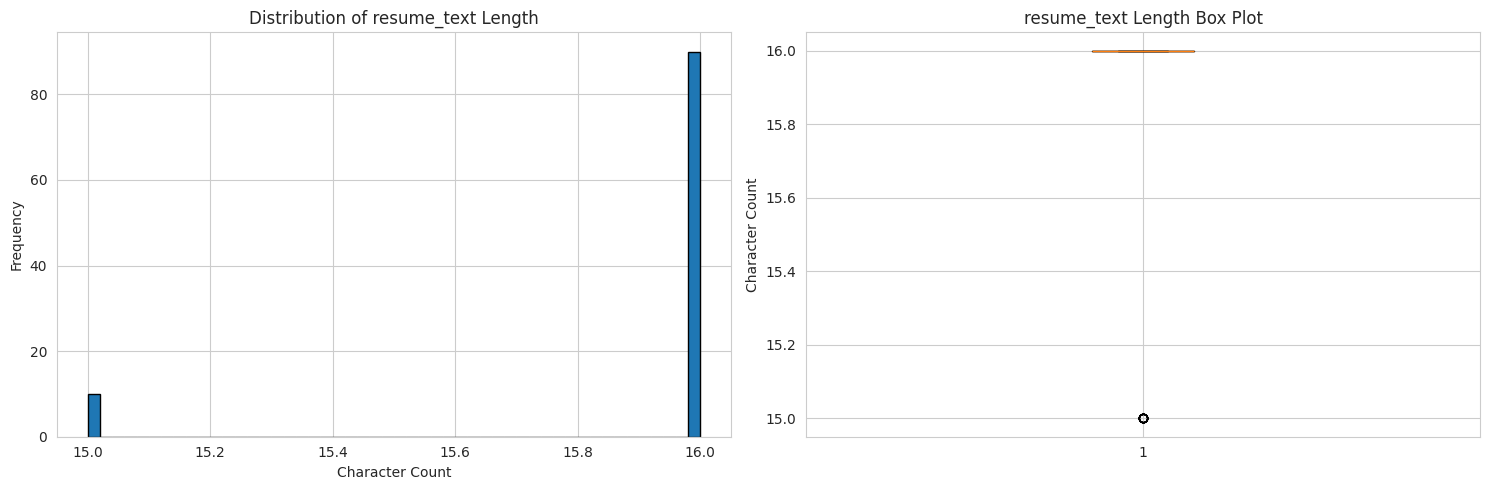


Text Length Statistics for resume_text:
count    100.000000
mean      15.900000
std        0.301511
min       15.000000
25%       16.000000
50%       16.000000
75%       16.000000
max       16.000000
Name: resume_text_length, dtype: float64


In [16]:
# Text length analysis
if len(text_cols_ds1) > 0:
    col = text_cols_ds1[0]
    df1_anonymized[f'{col}_length'] = df1_anonymized[col].astype(str).str.len()
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Distribution
    axes[0].hist(df1_anonymized[f'{col}_length'], bins=50, edgecolor='black')
    axes[0].set_title(f'Distribution of {col} Length')
    axes[0].set_xlabel('Character Count')
    axes[0].set_ylabel('Frequency')
    
    # Box plot
    axes[1].boxplot(df1_anonymized[f'{col}_length'])
    axes[1].set_title(f'{col} Length Box Plot')
    axes[1].set_ylabel('Character Count')
    
    plt.tight_layout()
    plt.savefig(OUTPUTS_PATH / 'text_length_analysis_ds1.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nText Length Statistics for {col}:")
    print(df1_anonymized[f'{col}_length'].describe())

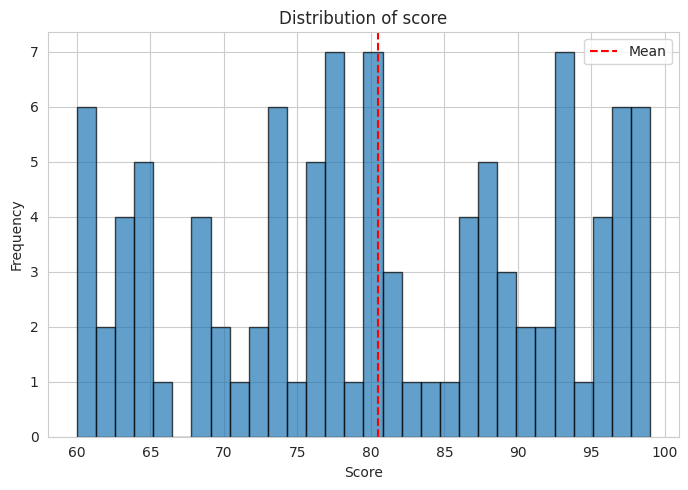

In [17]:
# Score distribution (if available)
score_cols = [col for col in df1_anonymized.columns if 'score' in col.lower()]
if score_cols:
    fig, axes = plt.subplots(1, len(score_cols), figsize=(7*len(score_cols), 5))
    if len(score_cols) == 1:
        axes = [axes]
    
    for idx, col in enumerate(score_cols):
        axes[idx].hist(df1_anonymized[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel('Score')
        axes[idx].set_ylabel('Frequency')
        axes[idx].axvline(df1_anonymized[col].mean(), color='red', linestyle='--', label='Mean')
        axes[idx].legend()
    
    plt.tight_layout()
    plt.savefig(OUTPUTS_PATH / 'score_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

## 9. Data Cleaning and Preprocessing

In [19]:
def clean_text(text: str) -> str:
    """Clean and normalize text."""
    if not isinstance(text, str):
        return ""
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^a-zA-Z0-9\s.,;!?()-]', '', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text

# Apply cleaning
print("Cleaning text columns...")
for col in text_cols_ds1:
    if col in df1_anonymized.columns:
        df1_anonymized[col] = df1_anonymized[col].apply(clean_text)

for col in text_cols_ds2:
    if col in df2_anonymized.columns:
        df2_anonymized[col] = df2_anonymized[col].apply(clean_text)

print("✅ Text cleaning complete")

Cleaning text columns...
✅ Text cleaning complete


In [20]:
# Remove duplicates
print(f"Dataset 1 before deduplication: {len(df1_anonymized)}")
df1_anonymized = df1_anonymized.drop_duplicates()
print(f"Dataset 1 after deduplication: {len(df1_anonymized)}")

print(f"\nDataset 2 before deduplication: {len(df2_anonymized)}")
df2_anonymized = df2_anonymized.drop_duplicates()
print(f"Dataset 2 after deduplication: {len(df2_anonymized)}")

Dataset 1 before deduplication: 100
Dataset 1 after deduplication: 100

Dataset 2 before deduplication: 6241
Dataset 2 after deduplication: 6240


In [21]:
# Handle missing values
print("\nHandling missing values...")
for col in df1_anonymized.columns:
    if df1_anonymized[col].dtype == 'object':
        df1_anonymized[col].fillna('', inplace=True)
    else:
        df1_anonymized[col].fillna(0, inplace=True)

for col in df2_anonymized.columns:
    if df2_anonymized[col].dtype == 'object':
        df2_anonymized[col].fillna('', inplace=True)
    else:
        df2_anonymized[col].fillna(0, inplace=True)

print("✅ Missing values handled")


Handling missing values...
✅ Missing values handled


## 10. Save Processed Data

In [22]:
# Save as Parquet (efficient columnar format)
print("Saving processed datasets...")

df1_path = PROCESSED_PATH / 'resume_scores_anonymized.parquet'
df2_path = PROCESSED_PATH / 'jd_resume_match_anonymized.parquet'

df1_anonymized.to_parquet(df1_path, index=False, engine='pyarrow')
df2_anonymized.to_parquet(df2_path, index=False, engine='pyarrow')

print(f"✅ Dataset 1 saved to: {df1_path}")
print(f"   Size: {df1_path.stat().st_size / 1024**2:.2f} MB")
print(f"✅ Dataset 2 saved to: {df2_path}")
print(f"   Size: {df2_path.stat().st_size / 1024**2:.2f} MB")

Saving processed datasets...
✅ Dataset 1 saved to: resume_screening_project/data/processed/resume_scores_anonymized.parquet
   Size: 0.00 MB
✅ Dataset 2 saved to: resume_screening_project/data/processed/jd_resume_match_anonymized.parquet
   Size: 27.67 MB


In [23]:
# Save metadata and statistics
metadata = {
    'creation_date': pd.Timestamp.now().isoformat(),
    'dataset1': {
        'name': 'resume_scores_anonymized',
        'rows': len(df1_anonymized),
        'columns': list(df1_anonymized.columns),
        'anonymization_stats': stats1,
    },
    'dataset2': {
        'name': 'jd_resume_match_anonymized',
        'rows': len(df2_anonymized),
        'columns': list(df2_anonymized.columns),
        'anonymization_stats': stats2,
    },
    'preprocessing_steps': [
        'PII anonymization',
        'Text cleaning',
        'Duplicate removal',
        'Missing value imputation'
    ]
}

metadata_path = PROCESSED_PATH / 'metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n✅ Metadata saved to: {metadata_path}")


✅ Metadata saved to: resume_screening_project/data/processed/metadata.json


## 12. Summary and Next Steps

In [25]:
print("="*80)
print(" " * 25 + "SETUP COMPLETE")
print("="*80)

print("\n📊 Processed Datasets:")
print(f"   1. Resume Scores: {len(df1_anonymized):,} records")
print(f"   2. JD-Resume Match: {len(df2_anonymized):,} records")

print("\n💾 Saved Files:")
print(f"   - {df1_path.name}")
print(f"   - {df2_path.name}")
print(f"   - metadata.json")

print("\n🔐 Anonymization Summary:")
if stats1:
    print("   Dataset 1:")
    for col, pii_stats in stats1.items():
        print(f"      {col}: {pii_stats}")
if stats2:
    print("   Dataset 2:")
    for col, pii_stats in stats2.items():
        print(f"      {col}: {pii_stats}")

print("\n📁 Storage Location:")
print(f"   {BASE_PATH}")

print("\n✅ Ready for Stage 1: Bi-Encoder Retrieval")
print("   👉 Open: 01_stage1_retriever_biencoder.ipynb")
print("="*80)

                         SETUP COMPLETE

📊 Processed Datasets:
   1. Resume Scores: 100 records
   2. JD-Resume Match: 6,240 records

💾 Saved Files:
   - resume_scores_anonymized.parquet
   - jd_resume_match_anonymized.parquet
   - metadata.json

🔐 Anonymization Summary:
   Dataset 1:
      resume_text: {'email': 0, 'phone': 0, 'ssn': 0, 'url': 0, 'linkedin': 0, 'github': 0, 'zipcode': 0, 'names': 0}

📁 Storage Location:
   resume_screening_project

✅ Ready for Stage 1: Bi-Encoder Retrieval
   👉 Open: 01_stage1_retriever_biencoder.ipynb


In [26]:
# Save current session variables for next notebooks
session_vars = {
    'BASE_PATH': str(BASE_PATH),
    'DATA_PATH': str(DATA_PATH),
    'PROCESSED_PATH': str(PROCESSED_PATH),
    'MODELS_PATH': str(MODELS_PATH),
    'OUTPUTS_PATH': str(OUTPUTS_PATH),
    'df1_path': str(df1_path),
    'df2_path': str(df2_path),
}

session_path = BASE_PATH / 'session_config.json'
with open(session_path, 'w') as f:
    json.dump(session_vars, f, indent=2)

print(f"Session configuration saved to: {session_path}")

Session configuration saved to: resume_screening_project/session_config.json
